In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Tuple, Type, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes

import torch
import torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class Sampleable(ABC):
    @abstractmethod
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        pass

In [3]:
class IsotropicGaussian(nn.Module, Sampleable):
    def __init__(self, shape: List[int], std: float = 1.0):
        super().__init__()
        self.shape = shape
        self.std = std
        self.dummy = nn.Buffer(torch.zeros(1))

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.std * torch.randn(num_samples, * self.shape).to(self.dummy.device), None

In [4]:
class ConditionalProbabilityPath(nn.Module, ABC):
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        t: shape(num_samples, 1, 1, 1)
        returns: x, sampled from p_t(x) shape(num_samples, c, h, w)
        """
        num_samples = t.shape[0]
        # samples z from p(z)
        z, _ = self.sample_conditioning_variable(num_samples) # shape(num_samples, c, h, w)
        # samples x from p_t(x|z)
        x = self.sample_confitional_path(z, t) # shape(nim_samples, c, h, w)
        return x
    
    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        '''
        Returns:
        - z: (num_samples, c, h, w)
        - y: (num_samples, label_dim)
        '''
        pass

    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        '''
        z: shape(num_samples, c, h, w), t: shape(num_samples, 1, 1, 1)
        Returns: samples form p_t(x|z)
        - x: (num_samples, c, h, w)
        '''
        pass

    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        evaluate the conditional velocity u_t(x|z): shape(num_samples, c, h, w)
        x: shape(num_samples, c, h, w), z: shape(num_samples, c, h, w), t: shape(num_samples, 1, 1, 1)
        """
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        pass

In [5]:
class Alpha(ABC):
    def __init__(self):
        assert torch.allclose(self(torch.zeros(1, 1, 1, 1)), torch.zeros(1, 1, 1, 1))
        assert torch.allclose(self(torch.ones(1, 1, 1, 1)), torch.ones(1, 1, 1, 1))

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        t = t.unsqueeze(1)
        return (vmap(jacrev(self)) (t)).view(-1, 1, 1, 1)
    
class Beta(ABC):
    def __init__(self):
        assert torch.allclose(self(torch.zeros(1, 1, 1, 1)), torch.ones(1, 1, 1, 1))
        assert torch.allclose(self(torch.ones(1, 1, 1, 1)), torch.zeros(1, 1, 1, 1))

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return (vmap(jacrev(self)) (t.unsqueeze(1))).view(-1, 1, 1, 1)
    
class LinearAlpha(Alpha):
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(num_samples, 1, 1, 1)
        return t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(num_samples, 1, 1, 1)
        return torch.ones_like(t)
    
class LinearBeta(Beta):
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(num_samples, 1, 1, 1)
        return 1 - t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(num_samples, 1, 1, 1)
        return - torch.ones_like(t)

In [6]:
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, p_simple_shape: List[int], alpha: Alpha, beta: Beta):
        p_simple = IsotropicGaussian(shape=p_simple_shape)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        return self.p_data.sample(num_samples)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)
    
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        alpha_d = self.alpha.dt(t)
        beta_d = self.beta.dt(t)
        alpha = self.alpha(t)
        beta = self.beta(t)

        return (alpha_d - beta_d * alpha / beta) * z + beta_d / beta * x
    
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

In [7]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        # x: shape(bs, c, h, w), t: shape(bs, 1)
        # returns: shape(bs, c, h, w)
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        # xt: shape(bs, c, h, w), t: shape(bs, 1, 1, 1)
        # returns: shape(bs, c, h, w)
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        # xt: shape(bs, c, h, w), t: shape(bs, c, h, w)
        # returns: shape(bs, c, h, w)
        pass

In [8]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - x_final: final state at time ts[-1], shape (bs, c, h, w)
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, nts, c, h, w)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.ode.drift_coefficient(xt,t, **kwargs) * h

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.sde.drift_coefficient(xt,t, **kwargs) * h + self.sde.diffusion_coefficient(xt,t, **kwargs) * torch.sqrt(h) * torch.randn_like(xt)

def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

In [9]:
MiB = 1024 ** 2

def model_size_b(model: nn.Module) -> torch.Tensor:
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buf in model.buffers():
        size += buf.nelement() * buf.element_size()
    return size

class Trainer(ABC):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)
    
    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs):
        # print the model size
        size_b = model_size_b(self.model)
        print(f'Training model with size: {size_b / MiB:.3f} MiB')

        # start
        self.model.to(device)
        opt = self.get_optimizer(lr=lr)
        self.model.train()

        # train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')
        
        # finish
        self.model.eval()


In [10]:
class MNISTSampler(nn.Module, Sampleable):
    def __init__(self):
        super().__init__()
        self.dataset = datasets.MNIST(
            root = "./data_mnist",
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize(0.5, 0.5),
            ])
        )
        self.dummy = nn.Buffer(torch.zeros(1))

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")
        
        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples, labels = zip(* [self.dataset[i] for i in indices])
        samples = torch.stack(samples).to(self.dummy)
        labels = torch.tensor(labels, dtype=torch.int64).to(self.dummy.device)
        return samples, labels


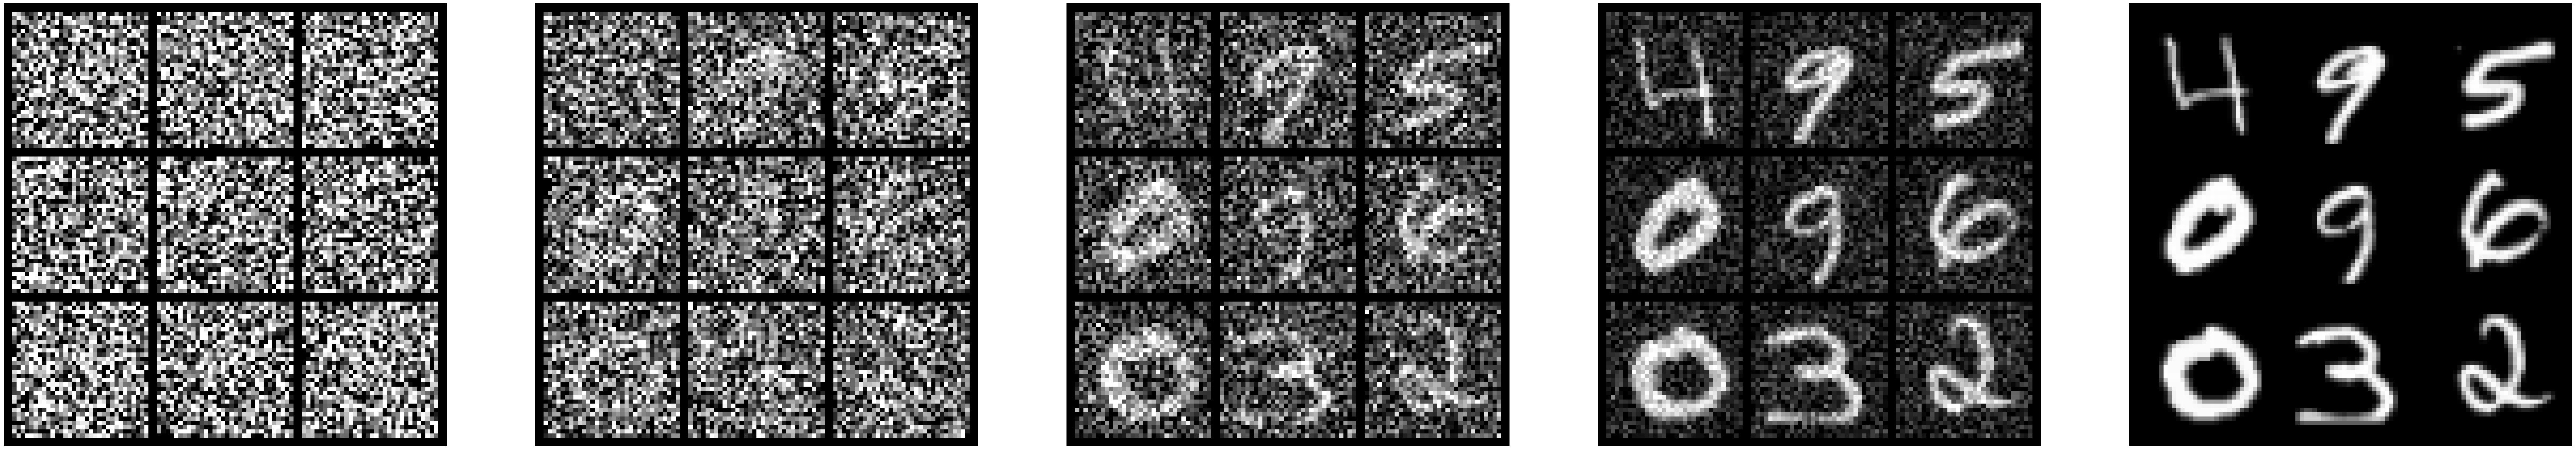

In [11]:
# Change these!
num_rows = 3
num_cols = 3
num_timesteps = 5

# Initialize our sampler
sampler = MNISTSampler().to(device)

# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Sample 
num_samples = num_rows * num_cols
z, _ = path.p_data.sample(num_samples)
z = z.view(-1, 1, 32, 32)

# Setup plot
fig, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows))

# Sample from conditional probability paths and graph
ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
    tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = path.sample_conditional_path(z, tt) # (num_samples, 1, 32, 32)
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[tidx].axis("off")
plt.show()

In [12]:
class ConditionalVectorField(nn.Module, ABC):
    @abstractmethod
    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """ 
        returns: u_t^theta(x | y), shape(bs, c, h, w)
        """
        pass

class CFGVectorFieldODE(ODE):
    def __init__(self, net: ConditionalVectorField, guidance_scale: float = 1.0):
        self.net = net
        self.guidance_scale = guidance_scale

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        guided_vector_field = self.net(x, t, y)
        unguided_y = torch.ones_like(y) * 10
        unguided_vector_field = self.net(x, t, unguided_y)
        return (1 - self.guidance_scale) * unguided_vector_field + self.guidance_scale * guided_vector_field


In [13]:
class CFGTrainer(Trainer):
    def __init__(self, path: GaussianConditionalProbabilityPath, model: ConditionalVectorField, eta: float, **kwargs):
        assert eta > 0 and eta < 1
        super().__init__(model, **kwargs)
        self.eta = eta
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        # sample (z, y) from the p_data
        z, y = self.path.p_data.sample(batch_size)

        # set all label to 10 with probability eta
        xi = torch.rand(y.shape[0]).to(y.device)
        y[xi < self.eta] = 10.0

        # sample t and x
        t = torch.rand(batch_size, 1, 1, 1).to(z)
        x = self.path.sample_conditional_path(z, t)

        # regress and output the loss
        ut_theta = self.model(x, t, y)
        ut_ref = self.path.conditional_vector_field(x, z, t)
        error = torch.einsum('bchw -> b', torch.square(ut_theta - ut_ref))
        return torch.mean(error)
        

In [14]:
class FourierEncoder(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(bs, 1, 1, 1)
        t = t.view(-1, 1)
        theta = self.weights * t * 2 * math.pi  # (bs, half_dim)
        sin_embed = torch.sin(theta)            # (bs, half_dim)
        cos_embed = torch.cos(theta)            # (bs, half_dim)
        return torch.cat([sin_embed, cos_embed], dim=-1) * math.sqrt(2) # (bs, dim)
    
class ResidualLayer(nn.Module):
    def __init__(self, channels: int, time_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(num_features=channels),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        )

        self.block2 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(num_features=channels),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        )

        self.time_adapter = nn.Sequential(
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, channels)
        )

        self.y_adapter = nn.Sequential(
            nn.Linear(y_embed_dim, y_embed_dim),
            nn.SiLU(),
            nn.Linear(y_embed_dim, channels)
        )

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        # x: shape(bs, c, h, w), t_embed: (bs, time_embed_dim), y_embed: (bs, y_embed_dim)
        res = x.clone()
        x = self.block1(x)

        t_embed = self.time_adapter(t_embed).unsqueeze(-1).unsqueeze(-1)  # (bs, c, 1, 1)
        x = x + t_embed

        y_embed = self.y_adapter(y_embed).unsqueeze(-1).unsqueeze(-1)           # (bs, c, 1, 1)
        x = x + y_embed

        x = self.block2(x)
        x = x + res
        return x

In [15]:
class Encoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_block = nn.ModuleList([
            ResidualLayer(channels=channels_in, time_embed_dim=t_embed_dim, y_embed_dim=y_embed_dim) for _ in range(num_residual_layers)
        ])
        self.downsample = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        # x: shape(bs, c, h, w), t_embed: shape(bs, t_embed_dim), t: shape(bs, y_embed_dim)
        for block in self.res_block:
            x = block(x, t_embed, y_embed)

        x = self.downsample(x)

        return x

class Midcoder(nn.Module):
    def __init__(self, channels: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_block = nn.ModuleList([
            ResidualLayer(channels=channels, time_embed_dim=t_embed_dim, y_embed_dim=y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        for block in self.res_block:
            x = block(x, t_embed, y_embed)

        return x
    
class Decoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Conv2d(in_channels=channels_in, out_channels=channels_out, kernel_size=3, padding=1)
        )
        self.res_block = nn.ModuleList([
            ResidualLayer(channels=channels_out, time_embed_dim=t_embed_dim, y_embed_dim= y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        x = self.upsample(x)

        for block in self.res_block:
            x = block(x, t_embed, y_embed)
        
        return x

In [16]:
class MNISTUnet(ConditionalVectorField):
    def __init__(self, channels: List[int], num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=channels[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(channels[0]),
            nn.SiLU()
        )

        self.time_embedder = FourierEncoder(t_embed_dim)
        self.y_embedder = nn.Embedding(num_embeddings=11, embedding_dim=y_embed_dim)

        encoders = []
        decoders = []

        for (curr_c, next_c) in zip(channels[:-1], channels[1:]):
            encoders.append(Encoder(curr_c, next_c, num_residual_layers, t_embed_dim, y_embed_dim))
            decoders.append(Decoder(next_c, curr_c, num_residual_layers, t_embed_dim, y_embed_dim))

        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

        self.midcoder = Midcoder(channels=channels[-1], num_residual_layers=num_residual_layers, t_embed_dim=t_embed_dim, y_embed_dim=y_embed_dim)

        self.final_conv = nn.Conv2d(in_channels=channels[0], out_channels=1, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        args: x: shape(bs, c, h, w), t: shape(bs, 1, 1, 1), y: shape(bs, )
        returns: u_t^theta(x|y)
        """

        t_embed = self.time_embedder(t)
        y_embed = self.y_embedder(y)

        x = self.init_conv(x)
        residuals = []

        for encoder in self.encoders:
            x = encoder(x, t_embed, y_embed)
            residuals.append(x.clone())
        
        x = self.midcoder(x, t_embed, y_embed)

        for decoder in self.decoders:
            res = residuals.pop()
            x = x + res
            x = decoder(x, t_embed, y_embed)

        x = self.final_conv(x)
        
        return x

In [17]:
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta(),
).to(device)

unet = MNISTUnet(
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
    y_embed_dim = 40,
).to(device)

trainer = CFGTrainer(path=path, model=unet, eta=0.1)

trainer.train(num_epochs = 5000, device=device, lr=1e-3, batch_size=250)

Training model with size: 4.715 MiB


Epoch 4999, loss: 146.577: : 5000it [07:37, 10.94it/s]


100%|██████████| 99/99 [00:01<00:00, 52.81it/s]


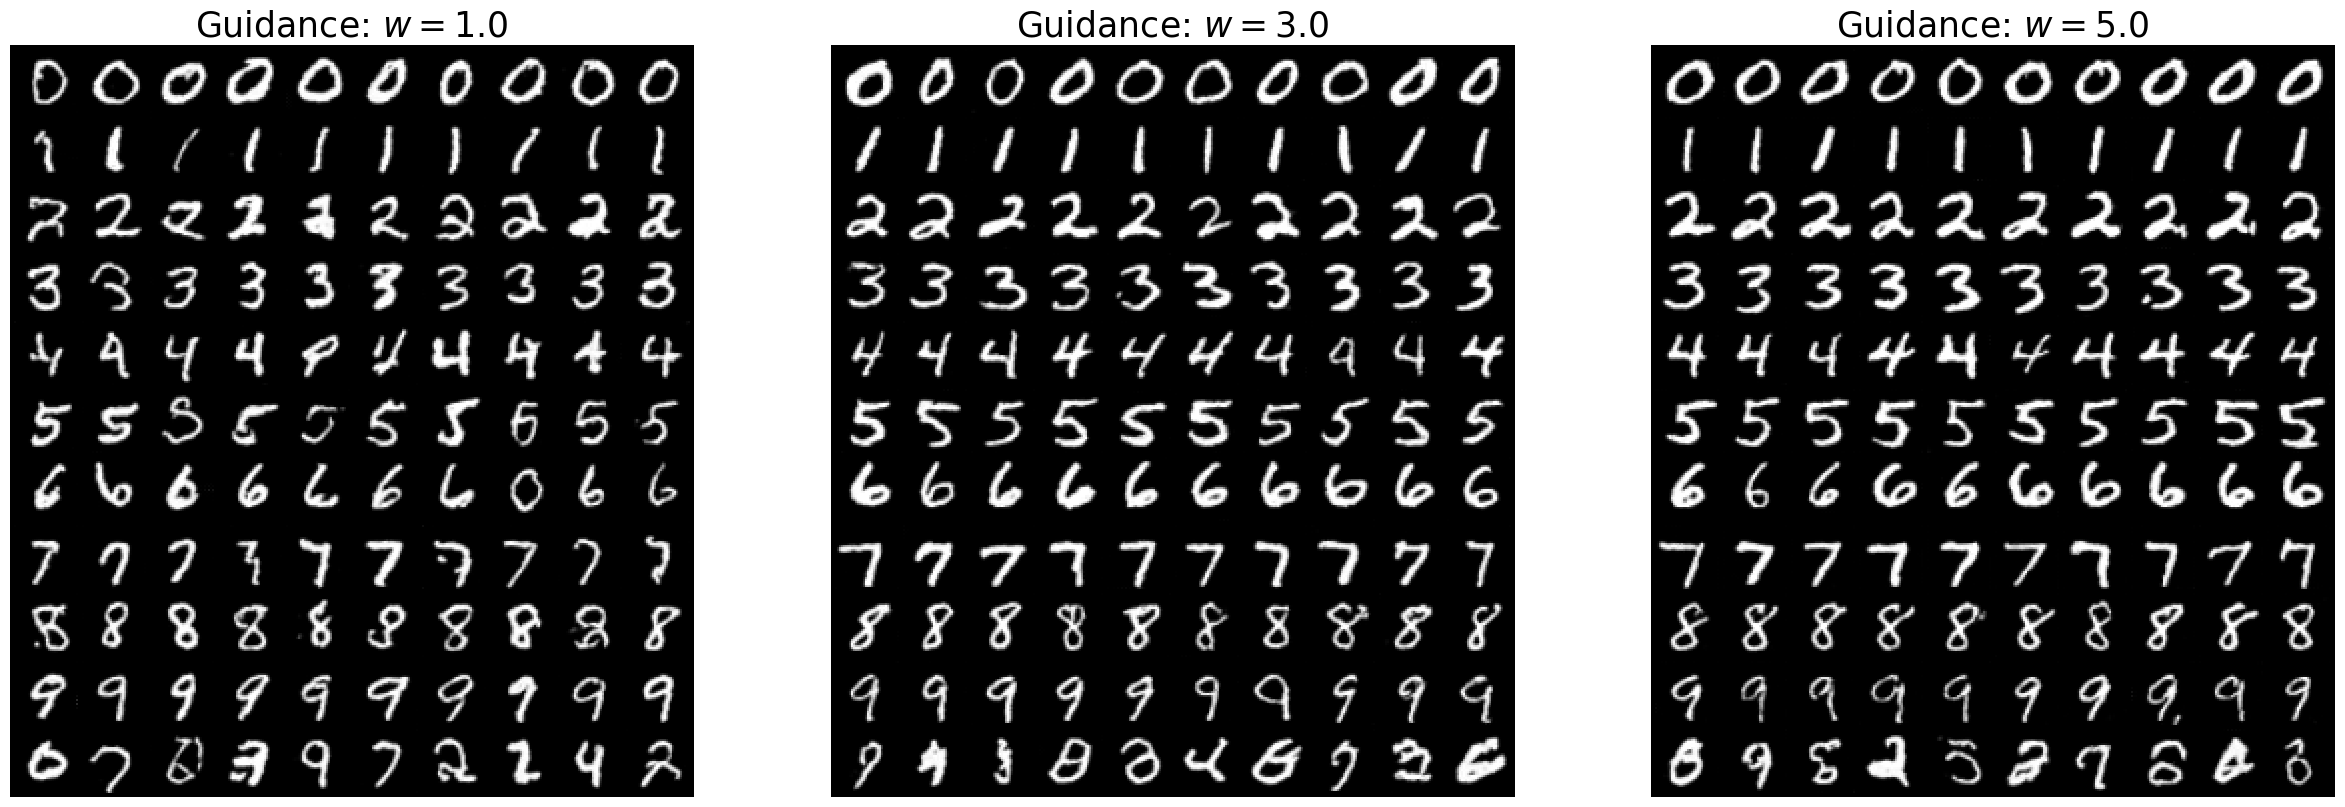

In [18]:
# Play with these!
samples_per_class = 10
num_timesteps = 100
guidance_scales = [1.0, 3.0, 5.0]

# Graph
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(unet, guidance_scale=w)
    simulator = EulerSimulator(ode)

    # Sample initial conditions
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64).repeat_interleave(samples_per_class).to(device)
    num_samples = y.shape[0]
    x0, _ = path.p_simple.sample(num_samples) # (num_samples, 1, 32, 32)

    # Simulate
    ts = torch.linspace(0,1,num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
    x1 = simulator.simulate(x0, ts, y=y)

    # Plot
    grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1,1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)